In [1]:
# Configs
dataset_dir = r'datasets\SpamURL1\URL.xlsx'

In [2]:
# from IPython.display import clear_output
# !pip install transformers datasets torch evaluate
# clear_output()

In [3]:
import torch
import matplotlib.pyplot as plt
from calflops import calculate_flops
from torch.utils.flop_counter import FlopCounterMode
torch.__version__

'2.3.1+cu118'

torch.Size([5000])
tensor(0.9929)


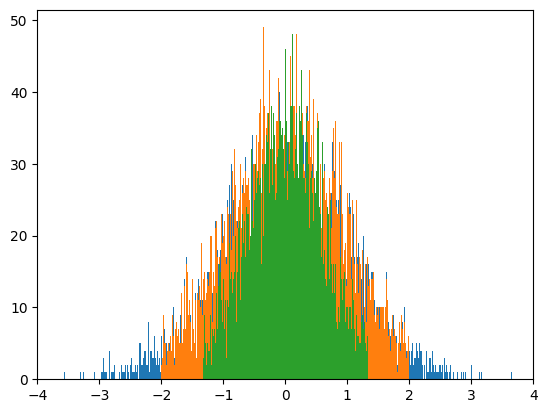

In [4]:
rand_nums = torch.randn(5000)
print(rand_nums.shape)
print(torch.std(rand_nums))
plt.hist(rand_nums, bins=500)
plt.hist(torch.fmod(rand_nums,2), bins=250)
plt.hist(torch.fmod(rand_nums,2.)*(2./3.), bins=250)
plt.xlim([-4, 4])
plt.show()

In [5]:
# importing libraries 
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset, load_metric

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

In [6]:
df = pd.read_excel(r'datasets\SpamURL1\URL.xlsx')
df.columns=['labels', 'text']
df.dropna(inplace=True)
class_list = df.labels.unique()
class_id = {t:i for i, t in enumerate(class_list)}
id_class = {i:t for i, t in enumerate(class_list)}
df['label'] = np.array([class_id[t] for t in df['labels']], dtype=int)
df = df.drop('labels', axis=1)
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=True)
print(df_train.label.value_counts())
print(df_test.label.value_counts())

label
0    20423
1    20412
Name: count, dtype: int64
label
1    2275
0    2263
Name: count, dtype: int64


In [7]:
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

In [8]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
def tokenize_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=64, padding='max_length')

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/40835 [00:00<?, ? examples/s]

Map:   0%|          | 0/4538 [00:00<?, ? examples/s]

In [10]:
# Set the format for PyTorch
train_dataset = train_dataset.rename_column('label', 'labels')
test_dataset = test_dataset.rename_column('label', 'labels')
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

In [11]:
training_args = TrainingArguments(
    output_dir=r'logs/OtherModels/bert_ag_results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    overwrite_output_dir=True,
    num_train_epochs=20,
    weight_decay=0.01,
    save_total_limit=3,
    save_strategy="no"
)

# Load the metrics
import evaluate;
accuracy_metric = evaluate.load('accuracy', trust_remote_code=True)
precision_metric = evaluate.load('precision', trust_remote_code=True)
recall_metric = evaluate.load('recall', trust_remote_code=True)

def compute_metrics(p):
    predictions, labels = p.predictions, p.label_ids
    predictions = np.argmax(predictions, axis=1)

    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="macro")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="macro")
    
    return {
        'accuracy': accuracy['accuracy'],
        'precision': precision['precision'],
        'recall': recall['recall']
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [12]:
torch.cuda.empty_cache()
import gc
gc.collect()

210

In [13]:
# Train the model
# trainer.train(resume_from_checkpoint=r"logs/OtherModels/bert_ag_results/last_epoch")
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

  0%|          | 0/3200 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.06750977784395218, 'eval_accuracy': 0.9748788012340238, 'eval_precision': 0.9749773900271319, 'eval_recall': 0.9748611441585371, 'eval_runtime': 2.7191, 'eval_samples_per_second': 1668.929, 'eval_steps_per_second': 6.62, 'epoch': 1.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.05295746773481369, 'eval_accuracy': 0.9803878360511239, 'eval_precision': 0.9803872552218813, 'eval_recall': 0.9803882816255772, 'eval_runtime': 2.7085, 'eval_samples_per_second': 1675.436, 'eval_steps_per_second': 6.646, 'epoch': 2.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.04430915415287018, 'eval_accuracy': 0.9850154252974879, 'eval_precision': 0.9850153205168671, 'eval_recall': 0.9850153205168671, 'eval_runtime': 2.697, 'eval_samples_per_second': 1682.598, 'eval_steps_per_second': 6.674, 'epoch': 3.0}
{'loss': 0.0888, 'learning_rate': 1.6875e-05, 'epoch': 3.12}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.05129655823111534, 'eval_accuracy': 0.9856765094755399, 'eval_precision': 0.9856938675294362, 'eval_recall': 0.9856699994658458, 'eval_runtime': 2.7473, 'eval_samples_per_second': 1651.779, 'eval_steps_per_second': 6.552, 'epoch': 4.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.07375992834568024, 'eval_accuracy': 0.9814896430145439, 'eval_precision': 0.9819861023201366, 'eval_recall': 0.9814487236139909, 'eval_runtime': 2.757, 'eval_samples_per_second': 1646.007, 'eval_steps_per_second': 6.529, 'epoch': 5.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.0559801384806633, 'eval_accuracy': 0.9865579550462759, 'eval_precision': 0.9865810023310023, 'eval_recall': 0.9865502857725571, 'eval_runtime': 2.6713, 'eval_samples_per_second': 1698.803, 'eval_steps_per_second': 6.738, 'epoch': 6.0}
{'loss': 0.0125, 'learning_rate': 1.375e-05, 'epoch': 6.25}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.06006975844502449, 'eval_accuracy': 0.9869986778316439, 'eval_precision': 0.9870070890906943, 'eval_recall': 0.9869945079224796, 'eval_runtime': 2.7083, 'eval_samples_per_second': 1675.564, 'eval_steps_per_second': 6.646, 'epoch': 7.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.06054010987281799, 'eval_accuracy': 0.9869986778316439, 'eval_precision': 0.9869992339236628, 'eval_recall': 0.9869980042052513, 'eval_runtime': 2.755, 'eval_samples_per_second': 1647.195, 'eval_steps_per_second': 6.534, 'epoch': 8.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.06708797067403793, 'eval_accuracy': 0.9878801234023799, 'eval_precision': 0.9879032634032634, 'eval_recall': 0.9878724633740099, 'eval_runtime': 2.8173, 'eval_samples_per_second': 1610.734, 'eval_steps_per_second': 6.389, 'epoch': 9.0}
{'loss': 0.005, 'learning_rate': 1.0625e-05, 'epoch': 9.38}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.06481275707483292, 'eval_accuracy': 0.988100484795064, 'eval_precision': 0.9881494302778822, 'eval_recall': 0.9880887473110187, 'eval_runtime': 2.7248, 'eval_samples_per_second': 1665.468, 'eval_steps_per_second': 6.606, 'epoch': 10.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.06332801282405853, 'eval_accuracy': 0.9874394006170119, 'eval_precision': 0.9874399609036904, 'eval_recall': 0.9874387300724021, 'eval_runtime': 2.7084, 'eval_samples_per_second': 1675.509, 'eval_steps_per_second': 6.646, 'epoch': 11.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.06822469830513, 'eval_accuracy': 0.988100484795064, 'eval_precision': 0.9881207147501077, 'eval_recall': 0.9880934090213807, 'eval_runtime': 2.6488, 'eval_samples_per_second': 1713.2, 'eval_steps_per_second': 6.795, 'epoch': 12.0}
{'loss': 0.0029, 'learning_rate': 7.500000000000001e-06, 'epoch': 12.5}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.07200969010591507, 'eval_accuracy': 0.9878801234023799, 'eval_precision': 0.9879641099207503, 'eval_recall': 0.9878643053808762, 'eval_runtime': 2.7601, 'eval_samples_per_second': 1644.172, 'eval_steps_per_second': 6.522, 'epoch': 13.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.0701107382774353, 'eval_accuracy': 0.988100484795064, 'eval_precision': 0.9881411131195261, 'eval_recall': 0.9880899127386091, 'eval_runtime': 2.769, 'eval_samples_per_second': 1638.882, 'eval_steps_per_second': 6.501, 'epoch': 14.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.07367971539497375, 'eval_accuracy': 0.988320846187748, 'eval_precision': 0.9883742660703019, 'eval_recall': 0.9883085275307988, 'eval_runtime': 2.754, 'eval_samples_per_second': 1647.791, 'eval_steps_per_second': 6.536, 'epoch': 15.0}
{'loss': 0.0013, 'learning_rate': 4.3750000000000005e-06, 'epoch': 15.62}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.07080157846212387, 'eval_accuracy': 0.9869986778316439, 'eval_precision': 0.9869981291042387, 'eval_recall': 0.9869991696328417, 'eval_runtime': 2.705, 'eval_samples_per_second': 1677.63, 'eval_steps_per_second': 6.654, 'epoch': 16.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.07245168834924698, 'eval_accuracy': 0.988100484795064, 'eval_precision': 0.988168341634837, 'eval_recall': 0.9880864164558376, 'eval_runtime': 2.729, 'eval_samples_per_second': 1662.864, 'eval_steps_per_second': 6.596, 'epoch': 17.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.07033517956733704, 'eval_accuracy': 0.988100484795064, 'eval_precision': 0.9881267554280229, 'eval_recall': 0.9880922435937902, 'eval_runtime': 2.762, 'eval_samples_per_second': 1643.018, 'eval_steps_per_second': 6.517, 'epoch': 18.0}
{'loss': 0.001, 'learning_rate': 1.25e-06, 'epoch': 18.75}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.07279624789953232, 'eval_accuracy': 0.988761568973116, 'eval_precision': 0.9888150512701763, 'eval_recall': 0.9887492533979498, 'eval_runtime': 2.722, 'eval_samples_per_second': 1667.155, 'eval_steps_per_second': 6.613, 'epoch': 19.0}


  0%|          | 0/18 [00:00<?, ?it/s]

{'eval_loss': 0.07124284654855728, 'eval_accuracy': 0.988320846187748, 'eval_precision': 0.9883504405662871, 'eval_recall': 0.9883120238135704, 'eval_runtime': 2.616, 'eval_samples_per_second': 1734.716, 'eval_steps_per_second': 6.881, 'epoch': 20.0}
{'train_runtime': 1214.3094, 'train_samples_per_second': 672.563, 'train_steps_per_second': 2.635, 'train_loss': 0.017448950172401965, 'epoch': 20.0}


  0%|          | 0/18 [00:00<?, ?it/s]

Evaluation results: {'eval_loss': 0.07124284654855728, 'eval_accuracy': 0.988320846187748, 'eval_precision': 0.9883504405662871, 'eval_recall': 0.9883120238135704, 'eval_runtime': 2.661, 'eval_samples_per_second': 1705.352, 'eval_steps_per_second': 6.764, 'epoch': 20.0}


In [14]:
trainer.save_model(r"logs/OtherModels/bert_spam_results/last_epoch")

In [32]:

dataset_list = test_dataset.to_list()
for _ in dataset_list[:100]:
    print(_['input_ids'])

[101, 11295, 19699, 9013, 5104, 25481, 1011, 2026, 1012, 3745, 8400, 1012, 4012, 1013, 3167, 1013, 4717, 1035, 2814, 25481, 1035, 4012, 1013, 1035, 9621, 2015, 1013, 2321, 1013, 24185, 8197, 15643, 1012, 2004, 2361, 2595, 1029, 4113, 6305, 9623, 16033, 7520, 1027, 17371, 28940, 2620, 2480, 3736, 2480, 2475, 2100, 2575, 9148, 2102, 2692, 3501, 2094, 2683, 11890, 12193, 4609, 2595, 2480, 102]
[101, 7479, 1012, 21210, 12054, 1012, 26226, 1011, 16545, 1012, 10507, 1013, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[101, 7479, 1012, 20116, 1012, 2149, 25688, 1012, 3968, 2226, 1012, 8740, 1013, 1066, 2848, 1013, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[101, 2739, 1012, 8224, 1012, 4012, 1013, 1029, 8476, 1027, 1038, 1004, 23713, 1025, 6434, 1027, 12667, 2015, 102, 0, 0, 0, 0, 

In [35]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from torchmetrics.classification import ConfusionMatrix
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def calculate_metrics(bert_model):
    cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))

    y_pred = []
    y_true = []

    bert_model = bert_model.eval()
    bert_model.to(device)
    dataset_list = test_dataset.to_list()
    for _ in tqdm(dataset_list):
        X = torch.tensor(_['input_ids']).unsqueeze(0).to(device)
        msk = torch.tensor(_['attention_mask']).unsqueeze(0).to(device)
        y = torch.tensor(_['labels']).to(device)
        with torch.no_grad():
            y_p = bert_model(X, attention_mask=msk).logits
            y_p = y_p.cpu()
        y_pred.append(y_p)
        y_true.append(y)
    # return y_pred, y_true
    y_pred = torch.cat(y_pred, dim=0)
    # y_pred = torch.tensor(y_pred)
    y_true = torch.tensor(y_true)
    y_pred2 = torch.argmax(y_pred, dim=1)
    # y_true2 = torch.argmax(y_true, dim=1)
    y_true2 = y_true
    print(f'classification report: \n {classification_report(y_true2, y_pred2, digits=4)}')
    print(f'confusion matrix:\n {cm(y_pred2, y_true2)}')
    print('================================')


In [36]:
calculate_metrics(trainer.model)

100%|██████████| 4538/4538 [01:19<00:00, 57.23it/s]


classification report: 
               precision    recall  f1-score   support

           0     0.9915    0.9850    0.9883      2263
           1     0.9852    0.9916    0.9884      2275

    accuracy                         0.9883      4538
   macro avg     0.9884    0.9883    0.9883      4538
weighted avg     0.9883    0.9883    0.9883      4538

confusion matrix:
 tensor([[2229,   34],
        [  19, 2256]])


In [19]:
trainer.model(test_dataset[0]['input_ids'].unsqueeze(0).to(device), attention_mask=test_dataset[0]['attention_mask'].unsqueeze(0).to(device)).logits

tensor([[ 5.4286, -5.1514]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [21]:
cm = ConfusionMatrix(task="multiclass", num_classes=len(class_id))
print(f'classification report: \n {classification_report(y_true, torch.argmax(y_pred, dim=1), digits=4)}')
print(f'confusion matrix:\n {cm(y_pred, y_true)}')

TypeError: argmax(): argument 'input' (position 1) must be Tensor, not list

In [15]:
p = 0.9901114463777985
r = 0.
(2*p*r)/(p+r)

0.0

In [37]:
calculate_flops(model, input_shape=(2, 64), transformer_tokenizer=tokenizer)


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  66.96 M 
fwd MACs:                                                               5.51 GMACs
fwd FLOPs:                                                              11.03 GFLOPS
fwd+bwd MACs:                                                           16.54 GMACs
fwd+bwd FLOPs:                                                          33.1 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each module cacul

c:\Users\fardin\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2654: FutureWarning: The `truncation_strategy` argument is deprecated and will be removed in a future version, use `truncation=True` to truncate examples to a max length. You can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to truncate to the maximal input size of the model (e.g. 512 for Bert).  If you have pairs of inputs, you can give a specific truncation strategy selected among `truncation='only_first'` (will only truncate the first sentence in the pairs) `truncation='only_second'` (will only truncate the second sentence in the pairs) or `truncation='longest_first'` (will iteratively remove tokens from the longest sentence in the pairs).
  warnings.warn(


('11.03 GFLOPS', '5.51 GMACs', '66.96 M')

In [38]:
from transformers import DistilBertTokenizer, DistilBertModel
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, max_length=64, truncation=True, padding='max_length', return_tensors='pt')
output = model(**encoded_input)
flopt_counter = FlopCounterMode(model)
with flopt_counter:
    model(**encoded_input)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)